In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import yfinance as yf

from lstm_functions import *
from lost_functions import *

# Reading and storing the Data

In [36]:
data = {}

for stock in ["XOM", "SHW", "UPS", "DUK", "UNH", "JPM", "AMZN", "AAPL", "MSFT", "AMT"]:
    s = pd.read_excel('data_for_testing.xlsx', sheet_name=stock).set_index('Date')
    s = s.drop(columns=['Sector', 'Ticker'])
    # monthly_data = data.resample('M').last().reset_index()
    data[stock] = s[-5000:]  # all stocks starting day diff, META don't even have 5000 trading days

data

{'XOM':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2003-11-03   36.919998   36.990002   36.549999   36.680000   19.106218   
 2003-11-04   36.520000   36.700001   36.200001   36.320000   18.918699   
 2003-11-05   36.240002   36.369999   35.930000   36.029999   18.767649   
 2003-11-06   35.900002   36.049999   35.750000   35.919998   18.710344   
 2003-11-07   35.900002   35.930000   35.490002   35.560001   18.652653   
 ...                ...         ...         ...         ...         ...   
 2023-09-08  114.529999  116.050003  114.320000  115.610001  115.610001   
 2023-09-11  116.180000  116.680000  113.570000  114.160004  114.160004   
 2023-09-12  115.339996  117.669998  115.269997  117.489998  117.489998   
 2023-09-13  117.410004  117.959999  115.900002  116.440002  116.440002   
 2023-09-14  117.550003  118.660004  117.320000  118.345001  118.345001   
 
               V

data preprocessing

In [37]:
train_size = int(len(data['XOM']) * 0.8)
sc = MinMaxScaler(feature_range = (0, 1))

train, test = [], []

for stock in data.keys():
    stock_data = data[stock].iloc[:train_size]
    stock_array = stock_data.values
    stock_scaled = sc.fit_transform(stock_array)
    train.append(stock_scaled)

    stock_data = data[stock].iloc[train_size:]
    stock_array = stock_data.values
    stock_scaled = sc.fit_transform(stock_array)
    test.append(stock_scaled)

train, test = np.array(train), np.array(test)
print(train.shape)
print(test.shape)

(10, 4000, 6)
(10, 1000, 6)


data structure creation

In [45]:
batch_size = 30

x_train, y_train = [], []
x_test, y_test = [], []

for i in range(batch_size, train.shape[1]):
    x_train.append(train[:, i-batch_size: i, :])
    y_train.append(train[:, i, :])

for i in range(batch_size, test.shape[1]):
    x_test.append(test[:, i-batch_size: i, :])
    y_test.append(test[:, i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(3970, 10, 30, 6) (3970, 10, 6)
(970, 10, 30, 6) (970, 10, 6)
[[[0.47873946 0.46253145 0.47116153 0.45645233 0.34393331 0.12449789]
  [0.26447494 0.25391714 0.33037243 0.27060537 0.26077399 0.17185201]
  [0.26382805 0.21592422 0.26674929 0.24516924 0.21512393 0.06472662]
  ...
  [0.06767514 0.06390082 0.07521415 0.0677625  0.06533663 0.11240602]
  [0.04153438 0.03537177 0.04856308 0.041852   0.03951678 0.08618835]
  [0.24739845 0.25813518 0.26482272 0.25629855 0.2096727  0.25060304]]

 [[0.47062911 0.46435914 0.48033482 0.47378024 0.3572682  0.11303008]
  [0.28377487 0.2575507  0.33381223 0.26184487 0.25224675 0.20234319]
  [0.27036313 0.23493514 0.27556289 0.25572152 0.22479727 0.07588982]
  ...
  [0.07115245 0.06890102 0.08003375 0.07162508 0.07038539 0.16069336]
  [0.03919753 0.0369342  0.05115497 0.04274151 0.04035678 0.0999449 ]
  [0.25052817 0.24499369 0.24622475 0.23849145 0.19257999 0.23763578]]

 [[0.46576295 0.45030847 0.46496965 0.44824438 0.34510419 0.10100174]
  [0.2736005

model initiation

In [43]:
# dbl cfm activation functions

model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True, batch_input_shape=(x_train.shape[0], x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=False))
model.add(Dropout(rate = 0.2))

model.add(Dense(units=x_train.shape[2], activation='sigmoid'))

In [44]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (3970, 10, 50)            16200     
                                                                 
 dropout_8 (Dropout)         (3970, 10, 50)            0         
                                                                 
 lstm_23 (LSTM)              (3970, 10, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (3970, 10, 50)            0         
                                                                 
 lstm_24 (LSTM)              (3970, 10, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (3970, 10, 50)            0         
                                                                 
 lstm_25 (LSTM)              (3970, 50)              

In [ ]:
inputs = tf.keras.Input(shape=(10, 128, 128, 3))
conv_2d_layer = tf.keras.layers.Conv2D(64, (3, 3))
outputs = tf.keras.layers.TimeDistributed(conv_2d_layer)(inputs)
outputs.shape

TensorShape([None, 10, 126, 126, 64])

In [ ]:
def custom_loss_1(y_true, y_pred):
    # y_true is the s&p500 returns
    # y_pred is the array of weights for each stock
    # we want to maximise y_pred - s&p500 returns (at least 20% higher)
    # aka minimise s&p500 returns - y_pred

    # <normalize>
    # predicted weights for day i * returns on day i = total returns
    # compare w s&p500 returns

    return y_true*1.2 - y_pred

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit([[50], [75], [90], [99], [100]])
scaler.transform([[50], [75], [90], [99], [100]])

array([[-1.  ],
       [ 0.  ],
       [ 0.6 ],
       [ 0.96],
       [ 1.  ]])

In [ ]:
xls = pd.ExcelFile('data_for_testing.xlsx')
all_data = {}
# This is too much data to load into memory at once
# for sheet in xls.sheet_names:
#     all_data[sheet] = pd.read_excel(xls, sheet_name=sheet)
for sheet in ["XOM", "SHW", "UPS", "DUK", "UNH", "JPM", "AMZN", "AAPL", "META", "AMT"]:
    data = pd.read_excel(xls, sheet_name=sheet).set_index('Date')
    # Resample to monthly data as a simple way to reduce the number of data points
    # Daily data is too much and take too long to train
    monthly_data = data.resample('M').last().reset_index()
    all_data[sheet] = monthly_data

In [ ]:
all_data

{'XOM':           Date        Open        High         Low       Close   Adj Close  \
 0   1962-01-31    0.000000    1.656250    1.636719    1.656250    0.101445   
 1   1962-02-28    0.000000    1.757813    1.726563    1.730469    0.107163   
 2   1962-03-31    0.000000    1.710938    1.703125    1.707031    0.105711   
 3   1962-04-30    0.000000    1.710938    1.671875    1.671875    0.103534   
 4   1962-05-31    0.000000    1.632813    1.609375    1.625000    0.101744   
 ..         ...         ...         ...         ...         ...         ...   
 736 2023-05-31  102.290001  103.040001  101.739998  102.180000  101.349197   
 737 2023-06-30  107.320000  107.879997  106.809998  107.250000  106.377975   
 738 2023-07-31  105.190002  107.860001  105.190002  107.239998  106.368050   
 739 2023-08-31  111.120003  111.419998  110.620003  111.190002  111.190002   
 740 2023-09-30  117.550003  118.660004  117.320000  118.345001  118.345001   
 
        Volume  Sector Ticker  
 0     1718

In [ ]:
all_data['XOM'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Sector,Ticker
0,1962-01-31,0.0,1.656250,1.636719,1.656250,0.101445,1718400,Energy,XOM
1,1962-02-28,0.0,1.757813,1.726563,1.730469,0.107163,2131200,Energy,XOM
2,1962-03-31,0.0,1.710938,1.703125,1.707031,0.105711,809600,Energy,XOM
3,1962-04-30,0.0,1.710938,1.671875,1.671875,0.103534,1222400,Energy,XOM
4,1962-05-31,0.0,1.632813,1.609375,1.625000,0.101744,3190400,Energy,XOM


In [ ]:
final_importance_values = {}
final_predictions = {}
# 30 is not a good number of batches, but it's a start for testing
# 60 is a good number of batches, but it takes a long time to train
time_steps = 30
features = 6

In [ ]:
# Loop through each stock data
for ticker, data in all_data.items():
    
    # Drop non-numeric columns
    data = data.drop(columns=['Sector', 'Ticker', 'Date'])  # Assuming 'Date' is the index
    lstm_model = LstmBuilder(time_step=time_steps, loss=huber_loss)
    model = lstm_model.create_model(features=features)
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    X, y = lstm_model.create_sequences(normalized_data)
    X_train, X_test, y_train, y_test = lstm_model.split_data(X,y)
    
    print("Working on: " + ticker)  
    model.fit(X_train, y_train, epochs=3, batch_size=4, validation_split=0.2, verbose=0)
    '''
    Batch Size: Refers to the number of training examples utilized in one iteration. When you set batch_size=32, it means the model takes 32 sequences at a time and updates weights once after computing the loss of the entire batch.
    Input Shape (60, 6): Refers to the shape of a single input sequence.
    60 indicates the number of time steps in each sequence. In your case, each sequence contains data from 60 days.
    6 refers to the number of features ('Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume').
    So, when you train your LSTM, it takes in 32 sequences (if we consider batch_size=32) at a time, and each of those sequences contains 60 time steps with 6 features for each time step.

    In simpler terms:

    Input Shape: Shape of a single sequence that you feed into the model.
    Batch Size: Number of sequences you feed into the model at one go.
    These two are different parameters and have different roles in the training process. The batch size is related to how you update the weights during training, whereas the input shape is related to the structure and size of your input data.
    '''
    
    # Predict the next day value
    last_days = normalized_data[-time_steps:].reshape(1, time_steps, features)
    prediction_next_day = model.predict(last_days)
    prediction_next_day_actual = scaler.inverse_transform(prediction_next_day)
    final_predictions[ticker] = prediction_next_day_actual.flatten()
    print(f"Predicted value for {ticker}: {prediction_next_day_actual.flatten()}")

    
    # Extracting importance
    dense_weights = model.layers[-1].get_weights()[0]

    # Think about to use sum or mean and to use abs() or not
    feature_weights = dense_weights.sum(axis=0)
    weighted_importance = prediction_next_day.flatten() * feature_weights
    final_importance_value = np.sum(weighted_importance)  # Final importance as a single value
    print(f"Importance value for {ticker}: {final_importance_value}")
    
    # Store the importance value in the dictionary
    final_importance_values[ticker] = final_importance_value

print(final_importance_values)

Working on: XOM
1/1 [==============================] - 0s 91ms/step
Predicted value for XOM: [1.9075950e+03 2.0908525e+03 2.0048762e+03 1.5263784e+03 7.2311902e+02
 6.9169000e+07]
Importance value for XOM: -24.918790817260742
Working on: SHW
1/1 [==============================] - 0s 76ms/step
Predicted value for SHW: [ 2.6219714e+02  9.8805305e+01  7.9222076e+01 -9.5004333e+01
 -1.9669167e+01  3.7300272e+06]
Importance value for SHW: 2.2704579830169678
Working on: UPS
1/1 [==============================] - 0s 79ms/step
Predicted value for UPS: [2.2529245e+02 1.8693488e+02 2.3212018e+02 1.6166748e+02 2.4483000e+01
 1.5402856e+07]
Importance value for UPS: 5.768479347229004
Working on: DUK
1/1 [==============================] - 0s 78ms/step
Predicted value for DUK: [8.9175026e+01 1.0547744e+02 9.3245598e+01 1.3195349e+02 7.3715202e+01
 7.6886980e+06]
Importance value for DUK: 2.8765580654144287
Working on: UNH
1/1 [==============================] - 0s 79ms/step
Predicted value for UNH: [

In [ ]:
final_importance_values

{'XOM': -24.91879,
 'SHW': 2.270458,
 'UPS': 5.7684793,
 'DUK': 2.876558,
 'UNH': 6.033467,
 'JPM': -4.34034,
 'AMZN': 1.0970883,
 'AAPL': 0.36141706,
 'META': 5.2468877,
 'AMT': 7.308773}

In [ ]:
importance_values = np.array(list(final_importance_values.values()))

# Run this if we want a arbitrage strategy
Each weight will be -1 to 1, the sum is 0

In [ ]:
## testing his normalization code

importance_values = [-24.02027, 5.5614214, 5.2308617, -5.3437276, 0.14171359, 100]

arbitrage_scaled_importance = 2 * (importance_values - np.min(importance_values)) / (np.max(importance_values) - np.min(importance_values)) - 1

# 2. Ensure the sum is zero
arbitrage_normalized_importance = arbitrage_scaled_importance - np.mean(arbitrage_scaled_importance)

arbitrage_normalized_importance


array([-0.60659874, -0.12955267, -0.1348834 , -0.30541342, -0.21695302,
        1.39340126])

In [ ]:
# 1. Scale the values to [-1, 1]
arbitrage_scaled_importance = 2 * (importance_values - np.min(importance_values)) / (np.max(importance_values) - np.min(importance_values)) - 1

# 2. Ensure the sum is zero
arbitrage_normalized_importance = arbitrage_scaled_importance - np.mean(arbitrage_scaled_importance)

# Convert back to dictionary
arbitrage_ticker_to_importance = dict(zip(final_importance_values.keys(), arbitrage_normalized_importance))

print(arbitrage_ticker_to_importance)

{'XOM': -0.6065987414530436, 'SHW': -0.1295526682587182, 'UPS': -0.13488340491974943, 'DUK': -0.3054134206986218, 'UNH': -0.21695302321682314, 'JPM': 1.3934012585469564}


# Run this instead if we want a normal strategy
Each weight will be 0 to 1, the sum is 1

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))  # subtract max to avoid potential overflow
    return e_x / e_x.sum(axis=0)

# Convert the importance values to probabilities using softmax
probabilities = softmax(importance_values)

# Convert back to dictionary
normalized_ticker_to_importance = dict(zip(final_importance_values.keys(), probabilities))

print(normalized_ticker_to_importance)

{'XOM': 1.3761985465852516e-54, 'SHW': 9.679355376651433e-42, 'UPS': 6.954824599716547e-42, 'DUK': 1.7774623085669577e-46, 'UNH': 4.286444844250463e-44, 'JPM': 1.0}


In [ ]:
def plot_importance(normalized_ticker_to_importance = normalized_ticker_to_importance, title='Normalized Importance Values'):
# Split the tickers and importance values based on positive and negative values
    long_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v > 0}
    short_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v <= 0}

    # Sort the positions for better visualization
    sorted_long = dict(sorted(long_positions.items(), key=lambda item: item[1], reverse=True))
    sorted_short = dict(sorted(short_positions.items(), key=lambda item: item[1]))

    # Create bar charts
    fig, ax = plt.subplots(figsize=(12, 7))

    # Positive cluster
    bars_long = ax.bar(sorted_long.keys(), sorted_long.values(), color='g', label='Long')

    # Negative cluster
    bars_short = ax.bar(sorted_short.keys(), sorted_short.values(), color='r', label='Short')

    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Annotate the bars
    for bar in bars_long:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=9)

    for bar in bars_short:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval - 0.02, round(yval, 3), ha='center', va='top', fontsize=9)

    ax.set_title(title)
    ax.set_ylabel('Importance Value')
    ax.set_xlabel('Ticker')
    ax.legend()

    plt.tight_layout()
    plt.show()


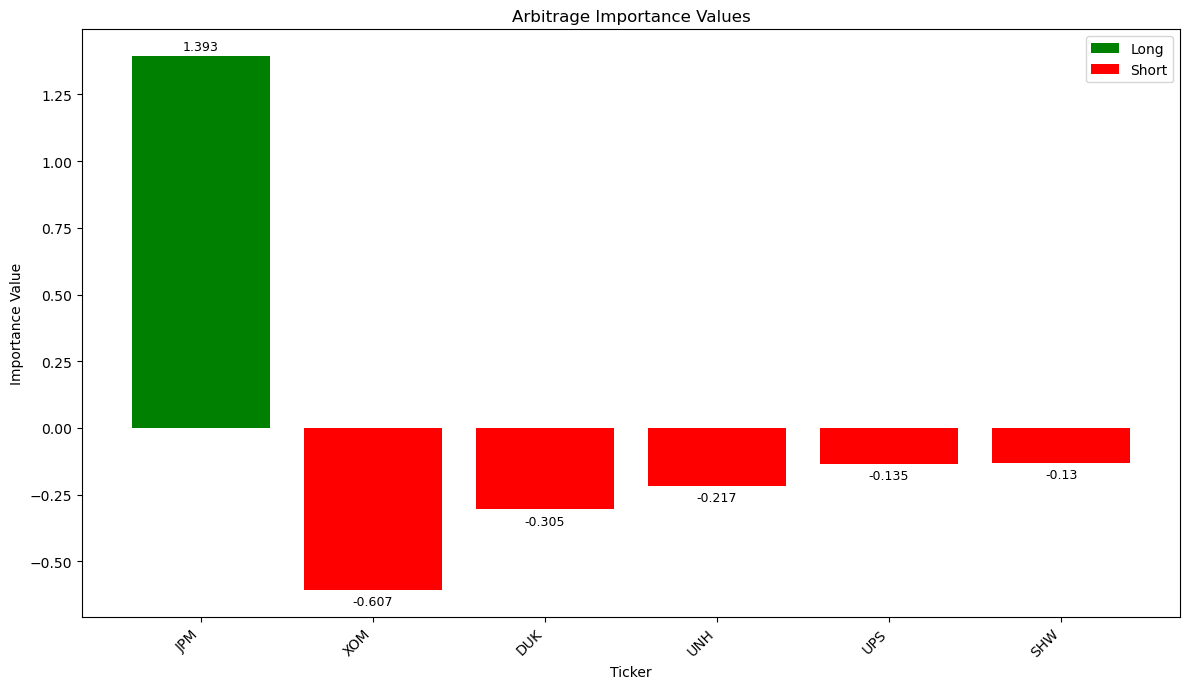

In [ ]:
# Plot the arbitrage importance values
plot_importance(arbitrage_ticker_to_importance, title='Arbitrage Importance Values')

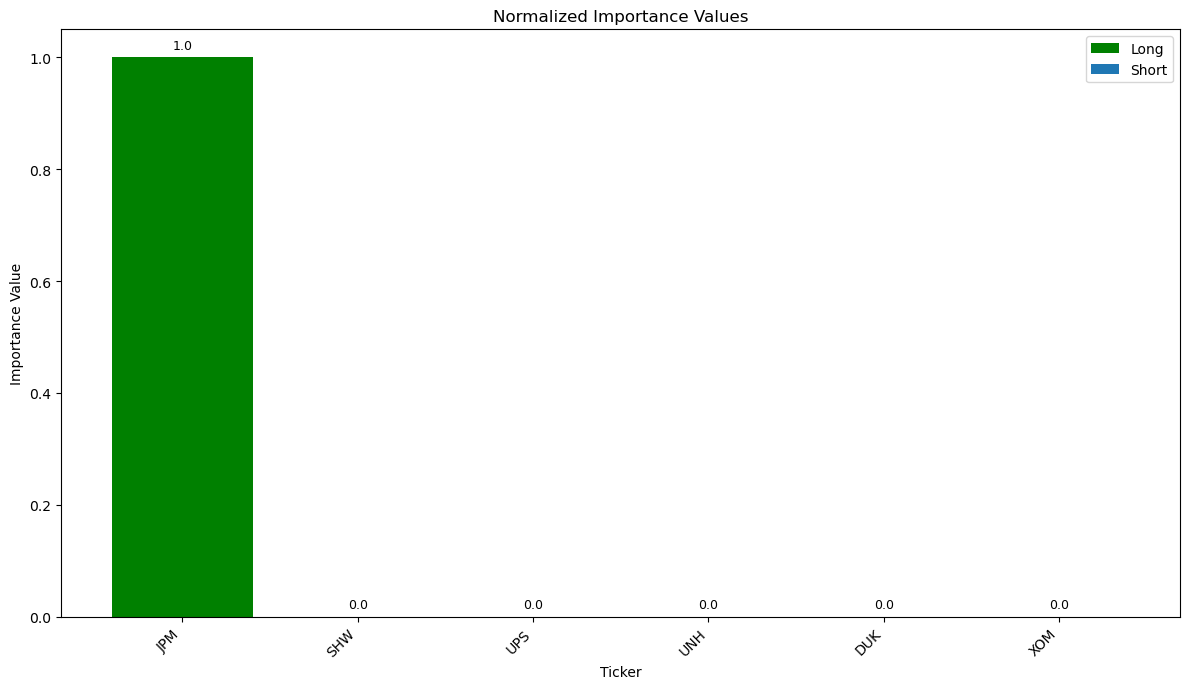

In [ ]:
# Plot the importance values
plot_importance(normalized_ticker_to_importance, title='Normalized Importance Values')

In [ ]:
spy_data = yf.download('SPY')
spy_monthly = spy_data.resample('M').last()
spy_monthly

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-31,43.968750,43.968750,43.750000,43.937500,24.941389,1003200
1993-02-28,44.437500,44.437500,44.187500,44.406250,25.207472,66200
1993-03-31,45.343750,45.468750,45.187500,45.187500,25.772116,111600
1993-04-30,44.125000,44.281250,44.031250,44.031250,25.112652,88500
1993-05-31,45.406250,45.406250,45.000000,45.218750,25.789932,79100
...,...,...,...,...,...,...
2023-06-30,441.440002,444.299988,441.109985,443.279999,441.721893,104921500
2023-07-31,457.410004,458.160004,456.049988,457.790009,456.180908,62040400
2023-08-31,451.649994,452.829987,450.160004,450.350006,448.767059,66084600


In [ ]:
all_data

{'XOM':           Date        Open        High         Low       Close   Adj Close  \
 0   1962-01-31    0.000000    1.656250    1.636719    1.656250    0.101445   
 1   1962-02-28    0.000000    1.757813    1.726563    1.730469    0.107163   
 2   1962-03-31    0.000000    1.710938    1.703125    1.707031    0.105711   
 3   1962-04-30    0.000000    1.710938    1.671875    1.671875    0.103534   
 4   1962-05-31    0.000000    1.632813    1.609375    1.625000    0.101744   
 ..         ...         ...         ...         ...         ...         ...   
 736 2023-05-31  102.290001  103.040001  101.739998  102.180000  101.349197   
 737 2023-06-30  107.320000  107.879997  106.809998  107.250000  106.377975   
 738 2023-07-31  105.190002  107.860001  105.190002  107.239998  106.368050   
 739 2023-08-31  111.120003  111.419998  110.620003  111.190002  111.190002   
 740 2023-09-30  117.550003  118.660004  117.320000  118.345001  118.345001   
 
        Volume  Sector Ticker  
 0     1718

In [ ]:
# Construct the Portfolio and Backtest
def build_portfolio(normalized_ticker_to_importance=normalized_ticker_to_importance, strategy='Normal'):
    portfolio_returns = pd.DataFrame()
    for ticker, importance in normalized_ticker_to_importance.items():
        data = all_data[ticker].set_index('Date')
        data['Returns'] = data['Adj Close'].pct_change().fillna(0)
        portfolio_returns[ticker] = data['Returns'] * importance
    portfolio_returns['Portfolio'] = portfolio_returns.sum(axis=1)
    spy_monthly['SPY Returns'] = spy_monthly['Adj Close'].pct_change().fillna(0)
    # Cumulative Returns
    portfolio_returns['Cumulative Portfolio'] = (portfolio_returns['Portfolio'] + 1).cumprod() - 1
    spy_monthly['Cumulative SPY'] = (spy_monthly['SPY Returns'] + 1).cumprod() - 1
    combined = pd.concat([portfolio_returns['Cumulative Portfolio'], spy_monthly['Cumulative SPY']], axis=1).dropna()
    print(combined)
    # Plot
    plt.figure(figsize=(14,7))
    combined['Cumulative Portfolio'].plot(label="Portfolio")
    combined['Cumulative SPY'].plot(label="SPY")
    plt.legend()
    plt.title(strategy + " Portfolio vs. SPY Cumulative Returns")
    plt.show()


            Cumulative Portfolio  Cumulative SPY
Date                                            
1993-01-31             -0.954480        0.000000
1993-02-28             -0.954238        0.010668
1993-03-31             -0.957044        0.033307
1993-04-30             -0.960409        0.006867
1993-05-31             -0.961109        0.034021
...                          ...             ...
2023-05-31             -0.986447       15.632607
2023-06-30             -0.985919       16.710397
2023-07-31             -0.984591       17.290116
2023-08-31             -0.985997       16.992866
2023-09-30             -0.986394       16.139383

[369 rows x 2 columns]


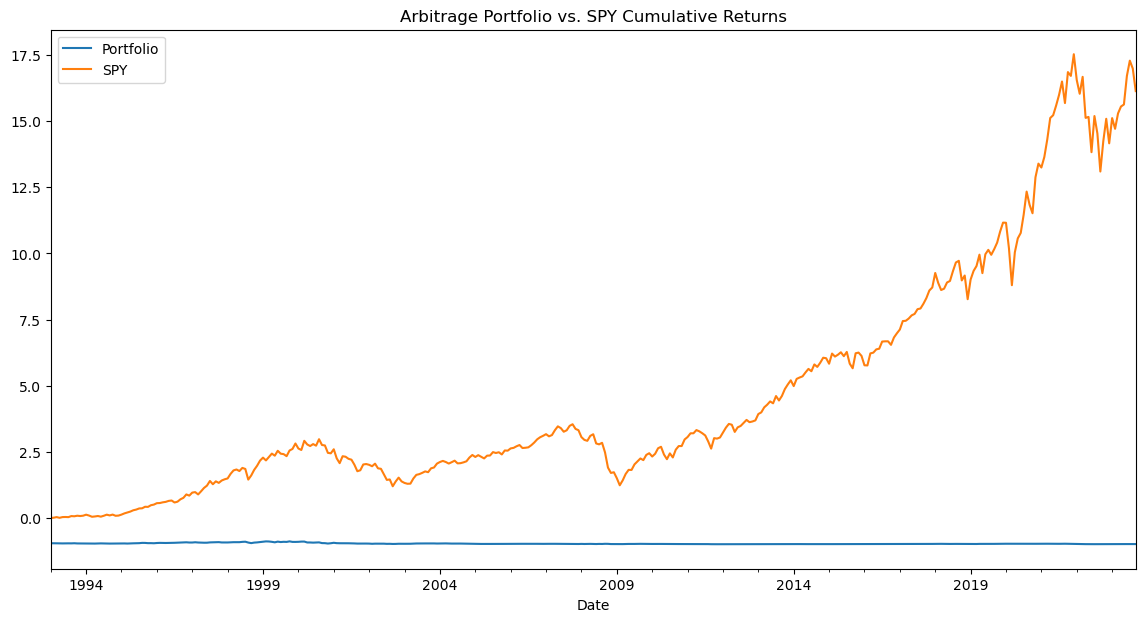

In [ ]:
# Build the portfolio for arbitrage strategy
build_portfolio(arbitrage_ticker_to_importance, strategy='Arbitrage')

            Cumulative Portfolio  Cumulative SPY
Date                                            
1993-01-31              3.892935        0.000000
1993-02-28              3.877881        0.010668
1993-03-31              3.902526        0.033307
1993-04-30              3.644500        0.006867
1993-05-31              3.659678        0.034021
...                          ...             ...
2023-05-31            118.625851       15.632607
2023-06-30            127.202653       16.710397
2023-07-31            139.195048       17.290116
2023-08-31            128.873011       16.992866
2023-09-30            131.535616       16.139383

[369 rows x 2 columns]


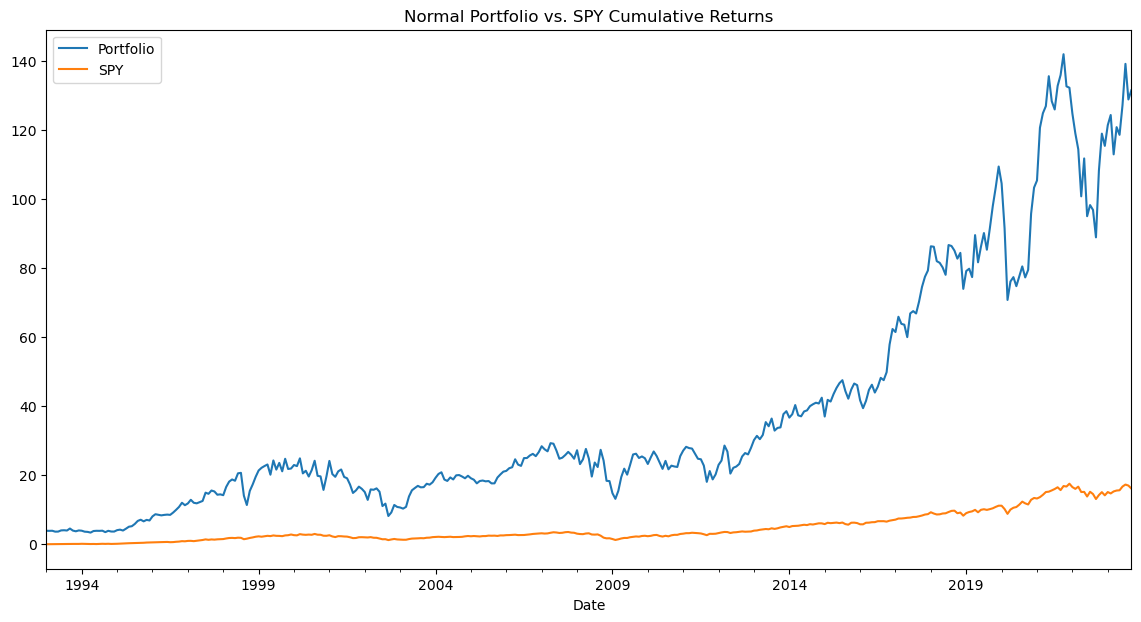

In [ ]:
# Build the portfolio for the Normal strategy
build_portfolio(normalized_ticker_to_importance, strategy='Normal')